Lambda School Data Science

*Unit 2, Sprint 3, Module 1*

---


# Define ML problems

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your decisions.

- [ ] Choose your target. Which column in your tabular dataset will you predict?
- [ ] Is your problem regression or classification?
- [ ] How is your target distributed?
    - Classification: How many classes? Are the classes imbalanced?
    - Regression: Is the target right-skewed? If so, you may want to log transform the target.
- [ ] Choose your evaluation metric(s).
    - Classification: Is your majority class frequency >= 50% and < 70% ? If so, you can just use accuracy if you want. Outside that range, accuracy could be misleading. What evaluation metric will you choose, in addition to or instead of accuracy?
    - Regression: Will you use mean absolute error, root mean squared error, R^2, or other regression metrics?
- [ ] Choose which observations you will use to train, validate, and test your model.
    - Are some observations outliers? Will you exclude them?
    - Will you do a random split or a time-based split?
- [ ] Begin to clean and explore your data.
- [ ] Begin to choose which features, if any, to exclude. Would some features "leak" future information?

If you haven't found a dataset yet, do that today. [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2) and choose your dataset.

Some students worry, ***what if my model isn't “good”?*** Then, [produce a detailed tribute to your wrongness. That is science!](https://twitter.com/nathanwpyle/status/1176860147223867393)

# Wrangle ML datasets (From 231 assignment)
[ ] Continue to clean and explore your data.

[ ] For the evaluation metric you chose, what score would you get just by guessing?

[ ] Can you make a fast, first model that beats guessing?

Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf), Chapter 8
  - _**[Gradient Boosting Explained](https://www.gormanalysis.com/blog/gradient-boosting-explained/)**_ — Ben Gorman
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) — Alex Rogozhnikov
  - [How to explain gradient boosting](https://explained.ai/gradient-boosting/) — Terence Parr & Jeremy Howard
  
# Model Interpretation

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Make at least 1 Shapley force plot to explain an individual prediction.
- [ ] **Share at least 1 visualization (of any type) on Slack!**

If you aren't ready to make these plots with your own dataset, you can practice these objectives with any dataset you've worked with previously. Example solutions are available for Partial Dependence Plots with the Tanzania Waterpumps dataset, and Shapley force plots with the Titanic dataset. (These datasets are available in the data directory of this repository.)

Please be aware that **multi-class classification** will result in multiple Partial Dependence Plots (one for each class), and multiple sets of Shapley Values (one for each class).

## Stretch Goals

#### Partial Dependence Plots
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

#### Shap Values
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!

### Links

#### Partial Dependence Plots
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [pdpbox repo](https://github.com/SauceCat/PDPbox) & [docs](https://pdpbox.readthedocs.io/en/latest/)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

#### Shapley Values
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

# Uploading Data Set

In [11]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df = pd.read_csv('/Users/bradbrauser/Desktop/Data Science/MoviesOnStreamingPlatforms_updated.csv')

In [13]:
df.shape

(16744, 17)

# Which column in your tabular dataset will you predict, and how is your target distributed?

The dataset has two rating features - IMDb and Rotten Tomatoes.

IMDb is great for seeing what general audiences think of a movie. If you don’t care what the critics say and want to see what people like yourself think of a movie, then you should use IMDb. Just be aware that fans often skew the vote with 10-star ratings, which may inflate scores somewhat.

Rotten Tomatoes offers the best overall picture of whether a movie is worth seeing at a glance. If you only trust the opinions of top critics and just want to know if a movie is at least decent, you should use Rotten Tomatoes. While the Fresh/Rotten binary can oversimplify the often complex opinions of critics, it should still help you weed out lousy films.

My goal with this project is more in line with IMDb, as even though scores may be skewed a bit by fans of the movies, I still want to know what the public thinks, because it seems that more often than not critics do not always line up with the public opinion.

In [14]:
print(df['IMDb'].isnull().sum())
print(df['Rotten Tomatoes'].isnull().sum())

571
11586


In [15]:
# Since the Rotten Tomatoes features has over 11,000 missing ratings, 
# I'm going to just drop the Rotten Tomatoes column

df = df.drop(['Rotten Tomatoes'], axis = 1)
df['Age'].unique()

array(['13+', '18+', '7+', nan, 'all', '16+'], dtype=object)

In [16]:
df = df.dropna(subset=['IMDb'], how='all')
df['IMDb'].isnull().sum()

df.head()

,Unnamed: 0,ID,Title,Year,Age,IMDb,Netflix,Hulu,Prime Video,Disney+,Type,Directors,Genres,Country,Language,Runtime
0,0,1,Inception,2010,13+,8.8,1,0,0,0,0,Christopher Nolan,"Action,Adventure,Sci-Fi,Thriller","United States,United Kingdom","English,Japanese,French",148.0
1,1,2,The Matrix,1999,18+,8.7,1,0,0,0,0,"Lana Wachowski,Lilly Wachowski","Action,Sci-Fi",United States,English,136.0
2,2,3,Avengers: Infinity War,2018,13+,8.5,1,0,0,0,0,"Anthony Russo,Joe Russo","Action,Adventure,Sci-Fi",United States,English,149.0
3,3,4,Back to the Future,1985,7+,8.5,1,0,0,0,0,Robert Zemeckis,"Adventure,Comedy,Sci-Fi",United States,English,116.0
4,4,5,"The Good, the Bad and the Ugly",1966,18+,8.8,1,0,1,0,0,Sergio Leone,Western,"Italy,Spain,West Germany",Italian,161.0


In [25]:
def wrangle(df, thresh=500):
    df = df.copy()
    
    # Setting Title as index
    df.set_index(df['Title'], inplace = True)    
    
    # Dropping rows if nulls exist
    df.dropna(subset=['IMDb'], how='all')
    
    # Creating new Rating colums
    df['Worth Watching?'] = df['IMDb'] >= 6.0
    
    # Replacing values in Age column
    df['Age'] = df['Age'].replace(to_replace ="13+", value = 'PG')
    df['Age'] = df['Age'].replace(to_replace ="18+", value = 'R')
    df['Age'] = df['Age'].replace(to_replace ="7+", value = 'G')
    df['Age'] = df['Age'].replace(to_replace ="all", value = 'G')
    df['Age'] = df['Age'].replace(to_replace ="16+", value = 'PG-13')
    
    # Rename Age to MPAA Rating
    df = df.rename(columns = {'Age': 'MPAA Rating'})
        
    # Dropping unnecessary values
    df.drop(['Unnamed: 0', 'ID', 'Type', 'Title', 'Language', 'IMDb'], axis=1, inplace=True)
    
    # Dropping other nulls
    df = df.dropna()
    
    # Split label and feature matrix
    y = df['Worth Watching?']
    df.drop(['Worth Watching?'], axis=1, inplace=True)
    
    return df, y

In [26]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

# Wrangling
X, y = wrangle(df)
X.head()

,Year,MPAA Rating,Netflix,Hulu,Prime Video,Disney+,Directors,Genres,Country,Runtime
Title,,,,,,,,,,
Inception,2010,PG,1,0,0,0,Christopher Nolan,"Action,Adventure,Sci-Fi,Thriller","United States,United Kingdom",148.0
The Matrix,1999,R,1,0,0,0,"Lana Wachowski,Lilly Wachowski","Action,Sci-Fi",United States,136.0
Avengers: Infinity War,2018,PG,1,0,0,0,"Anthony Russo,Joe Russo","Action,Adventure,Sci-Fi",United States,149.0
Back to the Future,1985,G,1,0,0,0,Robert Zemeckis,"Adventure,Comedy,Sci-Fi",United States,116.0
"The Good, the Bad and the Ugly",1966,R,1,0,1,0,Sergio Leone,Western,"Italy,Spain,West Germany",161.0


In [27]:
# Train test split on years movies were released
cutoff = 2010
X_train = X[X['Year'] < cutoff]
y_train = y.loc[X_train.index]
X_val = X[X['Year'] > cutoff]
y_val = y.loc[X_val.index]

# # Baseline
y_train.value_counts(normalize = True)

True     0.50762
False    0.49238
Name: Worth Watching?, dtype: float64

In [28]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

In [29]:
X_val.isnull().sum()

Year           0
MPAA Rating    0
Netflix        0
Hulu           0
Prime Video    0
Disney+        0
Directors      0
Genres         0
Country        0
Runtime        0
dtype: int64

In [30]:
from sklearn.ensemble import RandomForestClassifier
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
import category_encoders as ce
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

In [31]:
# Building model 1
model1 = Pipeline([
    ('oe', OrdinalEncoder()),
    ('impute', SimpleImputer()),
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(criterion='entropy', 
                                          max_depth=50, n_estimators=200, 
                                          min_samples_leaf=1, 
                                          random_state=42))
])

# Fitting the model
model1.fit(X_train, y_train)

print('Training Accuracy:', model1.score(X_train, y_train))
print('Validation Accuracy:', model1.score(X_val, y_val))

Training Accuracy: 1.0
Validation Accuracy: 0.5801393728222997


In [32]:
# Building model 2
model2 = Pipeline([
                  ('ohe', OneHotEncoder()),
                  ('impute', SimpleImputer()),
                  ('scaler', StandardScaler()),
                  ('classifier', RandomForestClassifier(criterion='entropy', 
                                                        max_depth=74, 
                                                        n_estimators=149, 
                                                        min_samples_leaf=1, 
                                                        random_state=42))
])

# Fitting the model
model2.fit(X_train, y_train)

print('Training Accuracy:', model2.score(X_train, y_train))
print('Validation Accuracy:', model2.score(X_val, y_val))

Training Accuracy: 0.9563305978898007
Validation Accuracy: 0.6591173054587689


In [33]:
# Model 3
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

model3 = make_pipeline(
    ce.OneHotEncoder(), 
    SimpleImputer(), 
    StandardScaler(), 
    RandomForestClassifier(criterion='entropy', 
                           max_depth=74, 
                           n_estimators=149, 
                           min_samples_leaf=1, 
                           random_state=42, 
                           min_samples_split = 40))

# Fitting the model
model3.fit(X_train, y_train)

print('Training Accuracy:', model3.score(X_train, y_train))
print('Validation Accuracy:', model3.score(X_val, y_val))

Training Accuracy: 0.8713364595545134
Validation Accuracy: 0.6594076655052264


In [34]:
X.isnull().sum()

Year           0
MPAA Rating    0
Netflix        0
Hulu           0
Prime Video    0
Disney+        0
Directors      0
Genres         0
Country        0
Runtime        0
dtype: int64

In [35]:
# Model 4
model4 = make_pipeline(
  OrdinalEncoder(),
  SimpleImputer(),
  StandardScaler(),
  RandomForestClassifier(
      min_samples_split=3,
      max_depth=15,
      n_estimators= 200,
      n_jobs=1)
)

param_distributions = {
    'randomforestclassifier__max_depth' : (11, 12, 13, 14, 15),
}

search = RandomizedSearchCV(
    model4,
    param_distributions=param_distributions,
    n_iter=40,
    cv=7,
    scoring='accuracy',
    verbose = 30,
    return_train_score=True,
    n_jobs=-1,
)

search.fit(X_train, y_train)

print('Cross-validation Best Score:', search.best_score_)
print('Best Estimator:', search.best_params_)
print('Best Model:', search.best_estimator_)

Fitting 7 folds for each of 5 candidates, totalling 35 fits


/Users/bradbrauser/opt/anaconda3/envs/unit2/lib/python3.7/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 5 is smaller than n_iter=40. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.0s
[

Cross-validation Best Score: 0.5539687615713469
Best Estimator: {'randomforestclassifier__max_depth': 15}
Best Model: Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['MPAA Rating', 'Directors', 'Genres',
                                      'Country'],
                                mapping=[{'col': 'MPAA Rating',
                                          'data_type': dtype('O'),
                                          'mapping': R        1
G        2
PG       3
PG-13    4
NaN     -2
dtype: int64},
                                         {'col': 'Directors',
                                          'data_type': dtype('O'),
                                          'mapping': Lana Wachowski,Lilly Wachowski       1
Robert Zemeckis                      2
Sergio Leone                         3
Roman Polanski                       4
Steven Spielberg                     5
                                  ... 
John Murlowski                    256...
United Kin

In [36]:
from xgboost import XGBClassifier

model5 = make_pipeline(ce.OrdinalEncoder(),
                       SimpleImputer(), 
                       StandardScaler(),
                       XGBClassifier()
)

model5.fit(X_train, y_train)

print('Training Accuracy:', model5.score(X_train, y_train))
print('Validation Accuracy:', model5.score(X_val, y_val))

Training Accuracy: 0.9830011723329426
Validation Accuracy: 0.5595238095238095


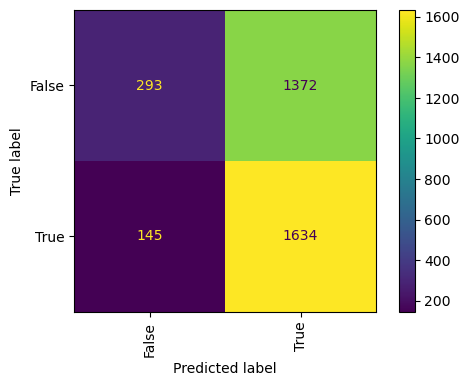

In [37]:
from sklearn.metrics import plot_confusion_matrix, classification_report
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 100
plot_confusion_matrix(model5, X_val, y_val, values_format='.0f', xticks_rotation='vertical')

In [38]:
y_pred = model5.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

       False       0.67      0.18      0.28      1665
        True       0.54      0.92      0.68      1779

    accuracy                           0.56      3444
   macro avg       0.61      0.55      0.48      3444
weighted avg       0.60      0.56      0.49      3444



In [39]:
import numpy as np

feature = 'Netflix'
print(X_val[feature].head())
print()
print(X_val[feature].value_counts())

X_val_permuted = X_val.copy()
X_val_permuted[feature] = np.random.permutation(X_val_permuted[feature])

acc = model5.score(X_val, y_val)
acc_permuted = model5.score(X_val_permuted, y_val)

print(f'Validation accuracy with {feature}:', acc)
print(f'Validation accuracy with {feature} permuted:', acc_permuted)
print(f'Permutation importance:', acc - acc_permuted)

Title
Avengers: Infinity War               1
Spider-Man: Into the Spider-Verse    1
Django Unchained                     1
Room                                 1
Her                                  1
Name: Netflix, dtype: int64

0    2265
1    1179
Name: Netflix, dtype: int64
Validation accuracy with Netflix: 0.5595238095238095
Validation accuracy with Netflix permuted: 0.5566202090592335
Permutation importance: 0.0029036004645760505


In [43]:
import eli5
from eli5.sklearn import PermutationImportance

# Ignore warnings

model8 = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_transformed = model8.fit_transform(X_train)
X_val_transformed = model8.transform(X_val)

model8 = RandomForestClassifier(n_estimators=20, random_state=42, n_jobs=-1)
model8.fit(X_train_transformed, y_train)

RandomForestClassifier(n_estimators=20, n_jobs=-1, random_state=42)

In [44]:
# Model 6
model6 = make_pipeline(
  OrdinalEncoder(),
  SimpleImputer(strategy='median'),
  StandardScaler(),
  RandomForestClassifier(
      min_samples_split=4,
      max_depth=15,
      n_estimators= 200,
      n_jobs=1)
)

param_distributions = {
    'randomforestclassifier__max_depth' : (11, 12, 13, 14, 15),
    'randomforestclassifier__min_samples_split': (2, 4, 6, 8, 10),
}

search = RandomizedSearchCV(
    model6,
    param_distributions=param_distributions,
    n_iter=40,
    cv=7,
    scoring='accuracy',
    verbose = 30,
    return_train_score=True,
    n_jobs=4,
)

search.fit(X_train, y_train)

print('Cross-validation Best Score:', search.best_score_)
print('Best Estimator:', search.best_params_)
print('Best Model:', search.best_estimator_)

/Users/bradbrauser/opt/anaconda3/envs/unit2/lib/python3.7/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 25 is smaller than n_iter=40. Running 25 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 7 folds for each of 25 candidates, totalling 175 fits


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Do

[Parallel(n_jobs=4)]: Done 136 tasks      | elapsed:   29.2s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:   29.7s
[Parallel(n_jobs=4)]: Done 138 tasks      | elapsed:   29.9s
[Parallel(n_jobs=4)]: Done 139 tasks      | elapsed:   29.9s
[Parallel(n_jobs=4)]: Done 140 tasks      | elapsed:   30.0s
[Parallel(n_jobs=4)]: Done 141 tasks      | elapsed:   30.5s
[Parallel(n_jobs=4)]: Done 142 tasks      | elapsed:   30.7s
[Parallel(n_jobs=4)]: Done 143 tasks      | elapsed:   30.7s
[Parallel(n_jobs=4)]: Done 144 tasks      | elapsed:   30.9s
[Parallel(n_jobs=4)]: Done 145 tasks      | elapsed:   31.4s
[Parallel(n_jobs=4)]: Done 146 tasks      | elapsed:   31.6s
[Parallel(n_jobs=4)]: Done 147 tasks      | elapsed:   31.6s
[Parallel(n_jobs=4)]: Done 148 tasks      | elapsed:   31.8s
[Parallel(n_jobs=4)]: Done 149 tasks      | elapsed:   32.3s
[Parallel(n_jobs=4)]: Done 150 tasks      | elapsed:   32.5s
[Parallel(n_jobs=4)]: Done 151 tasks      | elapsed:   32.5s
[Parallel(n_jobs=4)]: Do

Cross-validation Best Score: 0.5527965991661417
Best Estimator: {'randomforestclassifier__min_samples_split': 6, 'randomforestclassifier__max_depth': 15}
Best Model: Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['MPAA Rating', 'Directors', 'Genres',
                                      'Country'],
                                mapping=[{'col': 'MPAA Rating',
                                          'data_type': dtype('O'),
                                          'mapping': R        1
G        2
PG       3
PG-13    4
NaN     -2
dtype: int64},
                                         {'col': 'Directors',
                                          'data_type': dtype('O'),
                                          'mapping': Lana Wachowski,Lilly Wachowski       1
Robert Zemeckis                      2
Sergio Leone                         3
Roman Polanski                       4
Steven Spielberg                     5
                                  ... 
Joh

In [45]:
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint, uniform

model7 = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(), 
      StandardScaler(), 
    RandomForestRegressor(random_state=42)
)

param_distributions = {
    'targetencoder__min_samples_leaf': randint(1, 1000),     
    'simpleimputer__strategy': ['mean', 'median'], 
    'randomforestregressor__n_estimators': 15, 
    'randomforestregressor__max_depth': 14, 
    'randomforestregressor__max_features': 0.3763983510221083, 
}

search.fit(X_train, y_train);

print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)

Fitting 7 folds for each of 25 candidates, totalling 175 fits


/Users/bradbrauser/opt/anaconda3/envs/unit2/lib/python3.7/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 25 is smaller than n_iter=40. Running 25 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    2.6s
[Parallel(

[Parallel(n_jobs=4)]: Done 131 tasks      | elapsed:   27.9s
[Parallel(n_jobs=4)]: Done 132 tasks      | elapsed:   28.1s
[Parallel(n_jobs=4)]: Done 133 tasks      | elapsed:   28.6s
[Parallel(n_jobs=4)]: Done 134 tasks      | elapsed:   28.7s
[Parallel(n_jobs=4)]: Done 135 tasks      | elapsed:   28.8s
[Parallel(n_jobs=4)]: Done 136 tasks      | elapsed:   28.9s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:   29.4s
[Parallel(n_jobs=4)]: Done 138 tasks      | elapsed:   29.5s
[Parallel(n_jobs=4)]: Done 139 tasks      | elapsed:   29.6s
[Parallel(n_jobs=4)]: Done 140 tasks      | elapsed:   29.7s
[Parallel(n_jobs=4)]: Done 141 tasks      | elapsed:   30.3s
[Parallel(n_jobs=4)]: Done 142 tasks      | elapsed:   30.5s
[Parallel(n_jobs=4)]: Done 143 tasks      | elapsed:   30.5s
[Parallel(n_jobs=4)]: Done 144 tasks      | elapsed:   30.7s
[Parallel(n_jobs=4)]: Done 145 tasks      | elapsed:   31.3s
[Parallel(n_jobs=4)]: Done 146 tasks      | elapsed:   31.3s
[Parallel(n_jobs=4)]: Do

Best hyperparameters {'randomforestclassifier__min_samples_split': 10, 'randomforestclassifier__max_depth': 15}
Cross-validation MAE -0.5525026569014518


In [46]:
search.best_estimator_

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['MPAA Rating', 'Directors', 'Genres',
                                      'Country'],
                                mapping=[{'col': 'MPAA Rating',
                                          'data_type': dtype('O'),
                                          'mapping': R        1
G        2
PG       3
PG-13    4
NaN     -2
dtype: int64},
                                         {'col': 'Directors',
                                          'data_type': dtype('O'),
                                          'mapping': Lana Wachowski,Lilly Wachowski       1
Robert Zemeckis                      2
Sergio Leone                         3
Roman Polanski                       4
Steven Spielberg                     5
                                  ... 
John Murlowski                    256...
Germany,United States                     4
India                                     5
                                       .

In [47]:
# Partial Dependence Plot
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

In [48]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

processor = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

model = XGBClassifier(n_estimators=1000, n_jobs=-1)
model.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='auc', 
          early_stopping_rounds=10)

[0]	validation_0-auc:0.88951	validation_1-auc:0.50749
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.89936	validation_1-auc:0.55108
[2]	validation_0-auc:0.91013	validation_1-auc:0.57626
[3]	validation_0-auc:0.91540	validation_1-auc:0.59111
[4]	validation_0-auc:0.92008	validation_1-auc:0.59930
[5]	validation_0-auc:0.92520	validation_1-auc:0.60556
[6]	validation_0-auc:0.92896	validation_1-auc:0.61740
[7]	validation_0-auc:0.93410	validation_1-auc:0.62234
[8]	validation_0-auc:0.93676	validation_1-auc:0.62385
[9]	validation_0-auc:0.94102	validation_1-auc:0.62543
[10]	validation_0-auc:0.94412	validation_1-auc:0.62058
[11]	validation_0-auc:0.94757	validation_1-auc:0.62420
[12]	validation_0-auc:0.94836	validation_1-auc:0.61925
[13]	validation_0-auc:0.94994	validation_1-auc:0.60401
[14]	validation_0-auc:0.95435	validation_1-auc:0.60696
[15]	validation_0-auc:0.9571

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [49]:
from sklearn.metrics import roc_auc_score
X_val_processed = processor.transform(X_val)
class_index = 1
y_pred_proba = model.predict_proba(X_val_processed)[:, class_index]
print(f'Test ROC AUC for class {class_index}:')
print(roc_auc_score(y_val, y_pred_proba)) # Ranges from 0-1, higher is better

Test ROC AUC for class 1:
0.6254347095831075


# Partial Dependence Plot

In [50]:
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

gb = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBRegressor(n_estimators=200, objective='reg:squarederror', n_jobs=-1)
)

gb.fit(X_train, y_train)
y_pred = gb.predict(X_val)
print('Gradient Boosting R^2', r2_score(y_val, y_pred))

Gradient Boosting R^2 -0.22186764656571611


In [51]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

In [52]:
X_val.isnull().sum()

Year           0
MPAA Rating    0
Netflix        0
Hulu           0
Prime Video    0
Disney+        0
Directors      0
Genres         0
Country        0
Runtime        0
dtype: int64

In [53]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

In [54]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Runtime'

isolated = pdp_isolate(
    model=model3,
    dataset=X_val,
    model_features=X_val.columns,
    feature=feature
)

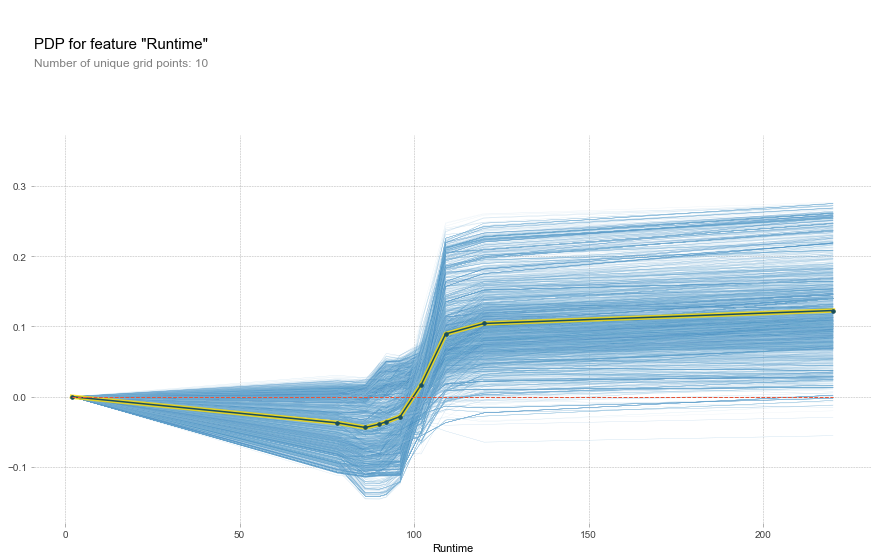

In [55]:
pdp_plot(isolated, feature_name=feature, plot_lines=True);

In [58]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['Runtime', 'Year']

interaction = pdp_interact(
    model=model3,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

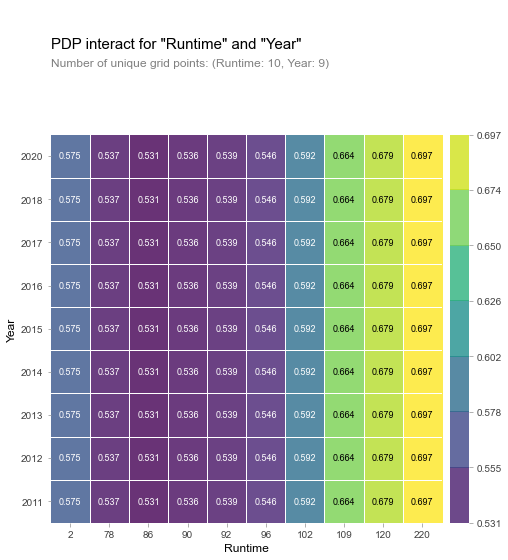

In [59]:
pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

In [60]:
row = X_val.iloc[[0]]
row

,Year,MPAA Rating,Netflix,Hulu,Prime Video,Disney+,Directors,Genres,Country,Runtime
Title,,,,,,,,,,
Avengers: Infinity War,2018,PG,1,0,0,0,"Anthony Russo,Joe Russo","Action,Adventure,Sci-Fi",United States,149.0


In [61]:
y_val.iloc[[0]]

Title
Avengers: Infinity War    True
Name: Worth Watching?, dtype: bool

In [62]:
model3.predict(row)

array([ True])

In [63]:
!pip install shap

In [68]:
import shap

explainer = shap.TreeExplainer(model3)
shap_values = explainer.shap_values(row)
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row
)

SHAPError: Model type not yet supported by TreeExplainer: <class 'sklearn.pipeline.Pipeline'>